|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -9.378    | 0.9722    | 0.05177   | 4.35      | 6.237     | 205.0     | 0.6842    | 0.1034    | 0.8727    |
| 2         | -10.08    | 0.641     | 0.07781   | 8.549     | 6.647     | 160.9     | 0.9635    | 0.8971    | 0.5984    |
| 3         | -12.12    | 0.798     | 0.0616    | 7.935     | 9.363     | 62.81     | 0.1348    | 0.117     | 0.6824    |
| 4         | -9.95     | 0.9017    | 0.09732   | 5.331     | 5.306     | 94.73     | 0.9025    | 0.7636    | 0.5994    |
| 5         | -10.22    | 0.6828    | 0.0636    | 3.281     | 8.422     | 210.1     | 0.01914   | 0.806     | 0.7024    |
| 6         | -8.573    | 0.5018    | 0.05187   | 5.358     | 5.819     | 284.2     | 0.8766    | 0.7521    | 0.7325    |
| 7         | -8.758    

| 38        | -7.26     | 0.5       | 0.1       | 4.284     | 2.053     | 157.9     | 0.1594    | 0.0       | 0.5       |
| 39        | -7.069    | 0.5       | 0.1       | 3.953     | 2.409     | 158.2     | 0.0       | 1.0       | 1.0       |
| 40        | -7.605    | 0.5       | 0.1       | 3.771     | 2.934     | 158.1     | 1.0       | 0.1002    | 1.0       |
| 41        | -7.345    | 1.0       | 0.1       | 3.578     | 2.986     | 157.3     | 0.0       | 0.4429    | 0.5       |
| 42        | -7.58     | 1.0       | 0.1       | 3.673     | 1.955     | 157.5     | 1.0       | 1.0       | 0.5       |
| 43        | -7.821    | 0.5       | 0.1       | 4.407     | 2.168     | 156.7     | 0.001043  | 0.9263    | 1.0       |
| 44        | -7.955    | 0.8138    | 0.1       | 3.194     | 1.0       | 180.7     | 0.02398   | 0.226     | 0.5       |
| 45        | -8.318    | 0.5       | 0.02346   | 3.0       | 1.643     | 157.2     | 0.06101   | 0.1633    | 1.0       |
| 46        | -7.382    

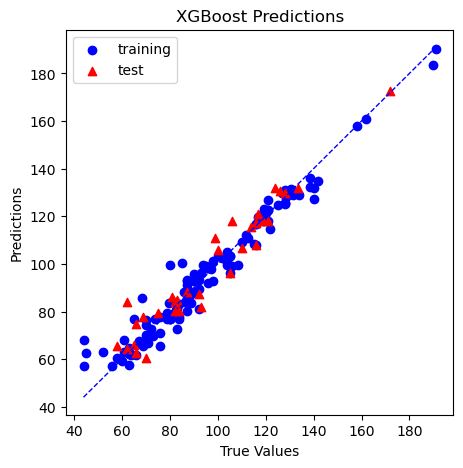

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from bayes_opt import BayesianOptimization

# 读取数据
data = pd.read_excel('HV.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=75)

# 定义目标函数
def xgb_evaluate(learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(x_train, y_train)
    predictions = xgb_model.predict(x_test)
    mse = mean_squared_error(y_test, predictions)
    return -np.sqrt(mse)

# 定义超参数范围
param_bounds = {
    'learning_rate': (0.01, 0.1),
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 1),       # L1 正则化
    'reg_lambda': (0, 1)       # L2 正则化
}

# 进行贝叶斯优化
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=37,
    verbose=2
)
optimizer.maximize(init_points=20, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

# 输出最佳参数
print("Best parameters found by Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 评价模型
xgb_MSE = mean_squared_error(y_train, xgb_model.predict(x_train))
xgb_RMSE = np.sqrt(xgb_MSE)
xgb_R2 = r2_score(y_train, xgb_model.predict(x_train))
print('RMSE_train: ' + str(xgb_RMSE))
print('R2_train: ' + str(xgb_R2))

xgb_MSE_t = mean_squared_error(y_test, xgb_model.predict(x_test))
xgb_RMSE_t = np.sqrt(xgb_MSE_t)
xgb_R2_t = r2_score(y_test, xgb_model.predict(x_test))
print('RMSE_test: ' + str(xgb_RMSE_t))
print('R2_test: ' + str(xgb_R2_t))

# 可视化结果
plt.figure(figsize=(5, 5))
plt.scatter(y_train, xgb_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, xgb_model.predict(x_test), c='red', label='test', marker='^')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions')
plt.show()

RMSE_train: 5.802836346134576
R2_train: 0.9567801710929387
RMSE_test: 6.913834382789007
R2_test: 0.9294434762338707


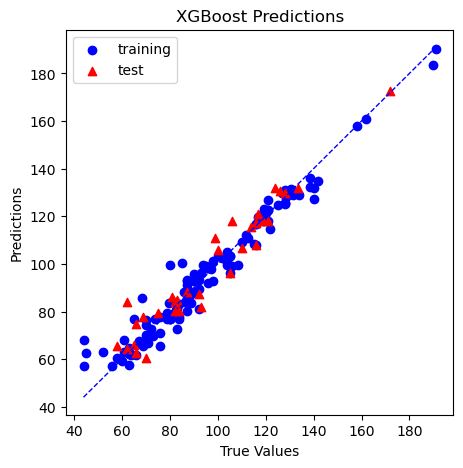

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# 读取数据
data = pd.read_excel('HV.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=75)

# 最佳参数
best_params = {
    'colsample_bytree': 0.7537221430165258,
    'learning_rate': 0.07141712725507017,
    'max_depth': 3,
    'min_child_weight': 1.036994365622379,
    'n_estimators': 179,
    'reg_alpha': 0.07844930740270828,
    'reg_lambda': 0.4659923785137676,
    'subsample': 0.5124079817369307,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 评价模型
xgb_MSE = mean_squared_error(y_train, xgb_model.predict(x_train))
xgb_RMSE = np.sqrt(xgb_MSE)
xgb_R2 = r2_score(y_train, xgb_model.predict(x_train))
print('RMSE_train: ' + str(xgb_RMSE))
print('R2_train: ' + str(xgb_R2))

xgb_MSE_t = mean_squared_error(y_test, xgb_model.predict(x_test))
xgb_RMSE_t = np.sqrt(xgb_MSE_t)
xgb_R2_t = r2_score(y_test, xgb_model.predict(x_test))
print('RMSE_test: ' + str(xgb_RMSE_t))
print('R2_test: ' + str(xgb_R2_t))

# 准备导出数据
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': xgb_model.predict(x_train),
    'Type': 'Train'
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_model.predict(x_test),
    'Type': 'Test'
})
results = pd.concat([train_results, test_results])

# 导出到Excel文件
results.to_excel('hvxgboost_predictions.xlsx', index=False)

# 可视化结果
plt.figure(figsize=(5, 5))
plt.scatter(y_train, xgb_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, xgb_model.predict(x_test), c='red', label='test', marker='^')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions')
plt.show()
